<h1>Содержание</h1>

1. Описание проекта
1. Исследовательский анализ данных
1. Подготовка данных
1. Обучение моделей
    - Модель LogisticRegression
    - Модель RandomForestClassifier  
    - Модель LGBMClassifier
1. Тестирование
1. Отчет

# Телеком

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

# Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

# Обозначения признаков

- `BeginDate` – дата начала пользования услугами,
- `EndDate` – дата окончания пользования услугами,
- `Type` – тип оплаты: ежемесячный, годовой и тд,
- `PaperlessBilling` – безналичный расчет,
- `PaymentMethod` – способ оплаты,
- `MonthlyCharges` – ежемесячные траты на услуги,
- `TotalCharges` – всего потрачено денег на услуги
- `Dependents` – наличие иждивенцев
- `Senior Citizen` – наличие пенсионного статуса по возрасту
- `Partner` – наличие супруга(и)
- `MultipleLines` – наличие возможности ведения параллельных линий во время звонка

# Цель проекта
Необходимо спрогнозировать, уйдет клиент или останется.

## Исследовательский анализ данных

**Загружаем необходимые библиотеки.**

In [1]:
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import phik
import copy

from scipy import stats as st
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV, train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve


warnings.simplefilter('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

**Создадим класс для датафреймов.**

In [2]:
class DataSet:
    
    def __init__(self, name, data):
        self.__name = name
        self.__data = data
        
    @property
    def name(self):
        return self.__name

    @name.setter
    def name(self, name):
        self.__name = name

    @property
    def data(self):
        return self.__data

    @data.setter
    def data(self, data):
        self.__data = data   

    @property
    def get_info(self):        
        print(f'Таблица {self.__name}')        
        display(self.__data.head())
        print()
        self.__data.info()
        print()   
        display(self.__data.describe())
        print()     
        print(f'Количество строк таблицы {self.__name}, '
              f'содержащих пропуски: {len(self.__data[self.__data.isna().sum(axis=1) >= 1])}')
        print()
        print(f'Количество столбцов таблицы {self.__name}, '
              f'содержащих пропуски: {self.__data.isna().any().sum()}')
        print()
        print(f'Количество дубликатов в таблице {self.__name}: '
              f'{self.__data.index.duplicated().sum()}') 
        print() 

contract = DataSet('contract', pd.read_csv('contract_new.csv', index_col='customerID'))
    
internet = DataSet('internet', pd.read_csv('internet_new.csv', index_col='customerID'))

personal = DataSet('personal', pd.read_csv('personal_new.csv', index_col='customerID'))
   
phone = DataSet('phone', pd.read_csv('phone_new.csv', index_col='customerID'))

In [3]:
contract.get_info

Таблица contract


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5



<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB



,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000



Количество строк таблицы contract, содержащих пропуски: 0

Количество столбцов таблицы contract, содержащих пропуски: 0

Количество дубликатов в таблице contract: 0



In [4]:
internet.get_info

Таблица internet


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No



<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB



,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785



Количество строк таблицы internet, содержащих пропуски: 0

Количество столбцов таблицы internet, содержащих пропуски: 0

Количество дубликатов в таблице internet: 0



In [5]:
personal.get_info

Таблица personal


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No



<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB



,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000



Количество строк таблицы personal, содержащих пропуски: 0

Количество столбцов таблицы personal, содержащих пропуски: 0

Количество дубликатов в таблице personal: 0



In [6]:
phone.get_info

Таблица phone


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes



<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB



,MultipleLines
count,6361
unique,2
top,No
freq,3390



Количество строк таблицы phone, содержащих пропуски: 0

Количество столбцов таблицы phone, содержащих пропуски: 0

Количество дубликатов в таблице phone: 0



**Из полученной информации видно, что:**
- количество данных в таблицах с информацией о договорах и персональными данными клиентов совпадают;
- в таблице с информацией об интернет-услугах - 5517 строк;
- в таблице с информацией об услугах телефонии - 6361 строк;
- пропущенные значения и дубликаты отсутствуют во всех таблицах.

**Объединим данные и посмотрим информацию о полученной таблице.**

In [7]:
df = contract.data.join(personal.data, on='customerID', how='inner')
df = df.join(internet.data, on='customerID', how='left')
df = df.join(phone.data, on='customerID', how='left')

full_data = DataSet('full data', df)

full_data.get_info

Таблица full data


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No



<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null

,MonthlyCharges,SeniorCitizen
count,7043.000000,7043.000000
mean,64.761692,0.162147
std,30.090047,0.368612
min,18.250000,0.000000
25%,35.500000,0.000000
50%,70.350000,0.000000
75%,89.850000,0.000000
max,118.750000,1.000000



Количество строк таблицы full data, содержащих пропуски: 2208

Количество столбцов таблицы full data, содержащих пропуски: 8

Количество дубликатов в таблице full data: 0



**Из информации видно, что в 8 столбцах содержатся пропуски. Это произошло в результате объединения таблиц, поскольку среди клиентов были те, кто пользуется только интернет-услугами или только услугами телефонии.**

**Заполним пропуски по аналогии с заполненными данными в таблице.**

In [8]:
full_data.data[
    ['InternetService',
     'OnlineSecurity', 
     'OnlineBackup',
     'DeviceProtection',
     'TechSupport', 
     'StreamingTV',
     'StreamingMovies',
     'MultipleLines'
    ]
] = full_data.data[
    ['InternetService', 
     'OnlineSecurity', 
     'OnlineBackup', 
     'DeviceProtection', 
     'TechSupport', 
     'StreamingTV', 
     'StreamingMovies', 
     'MultipleLines']].fillna('No')

In [9]:
full_data.data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   7043 non-null   object 
 12  OnlineSecurity    7043 non-null   object 
 13  OnlineBackup      7043 non-null   object 
 14  DeviceProtection  7043 non-null   object 
 15  TechSupport       7043 non-null   object 
 16  StreamingTV       7043 non-null 

**Пропуски заполнены.**

**В таблице содержатся строки с пробелом вместо значения признака TotalCharges.** 

In [10]:
full_data.data[full_data.data.TotalCharges == ' ']

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,No,No,No,No,No,No,No,No
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,No
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,No,No,No,No,No,No,No,No
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,No,No,No,No,No,No,No,No
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,No,No,No,No,No,No,No,No


**По дате начала пользования услугами (BeginDate) видно, что это новые клиенты.** 

**Заменим пробел на 0 и изменим тип данных столбца.**

In [11]:
full_data.data.TotalCharges = full_data.data.TotalCharges.replace([' '], 0)

full_data.data.TotalCharges = full_data.data.TotalCharges.astype(float)

**Создадим новый столбец 'CurrentClient' для целевого признака со значениями:**
- 0 - клиент ушел;
- 1 - клиент пользуется услугами связь.

In [12]:
full_data.data['CurrentClient'] = np.where(full_data.data.EndDate == 'No', 1, 0)

In [13]:
full_data.data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,CurrentClient
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,1
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1


**Посмотрим на распределение целевого признака.**

In [14]:
class_frequency = round(full_data.data['CurrentClient'].value_counts(normalize=True), 4)
print(class_frequency * 100)

CurrentClient
1    84.37
0    15.63
Name: proportion, dtype: float64


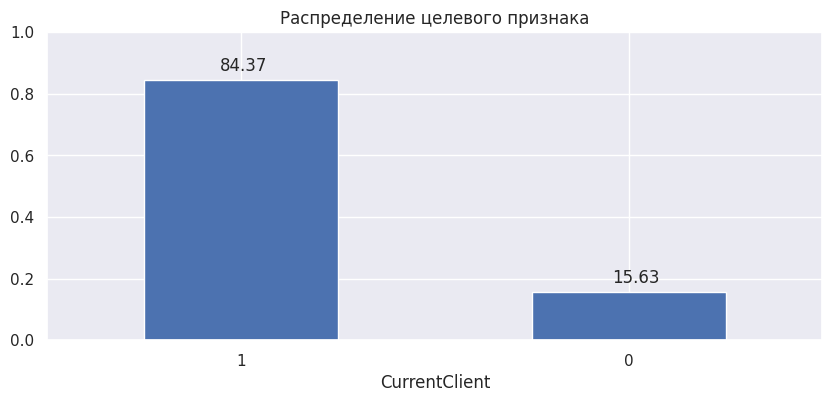

In [15]:
sns.set(rc={'figure.figsize':(10, 4)})

class_frequency.plot(kind='bar').set(ylim=(0,1))

plt.xticks(rotation=0)

plt.text(x=(class_frequency[0]+0.8),
         y=(class_frequency[0]+0.03), 
         s = str(round(class_frequency[0] * 100, 2)), 
         size = 12)

plt.text(x=(class_frequency[1]-0.9), 
         y=(class_frequency[1]+0.03), 
         s = str(round(class_frequency[1] * 100, 2)),
         size = 12)

plt.title('Распределение целевого признака')
plt.show()

**Наблюдается дисбаланс классов, это следует учесть при обучении моделей.**

**Выводы по шагу 1:**
1. В нашем распоряжении 4 датафрейма, содержащие:
    - информацию о договоре;
    - персональные данные клиентов;
    - информацию об интернет-услугах;
    - информацию об услугах телефонии.
2. Пропущенных значений и дубликатов в исходных данных нет;
3. Исходные таблицы объединены в одну;
4. При исследовании распределения целевого признака обнаружен дисбаланс классов.

## Подготовка данных

**Добовим новый признак в данные. Для начала переопределим признак `EndDate` следующим образом: если клиент ушел - оставим дату окончания пользования услугами, иначе поставим дату актуальности данных - 1 февраля 2020 года.**

In [16]:
full_data.data['EndDate'] = np.where(full_data.data.EndDate == 'No', '2020-02-01', full_data.data['EndDate'])

**Изменим тип данных `EndDate` и `BeginDate` на `datetime64[ns]`.**

In [17]:
full_data.data[['BeginDate', 'EndDate']] = full_data.data[['BeginDate', 'EndDate']].astype('datetime64[ns]')

**Определим новый признак как разницу дат `EndDate` и `BeginDate` в днях и удалим признаки `EndDate` и `BeginDate`.**

In [18]:
full_data.data['ClientInCompany'] = (full_data.data['EndDate'] - full_data.data['BeginDate']).dt.days
full_data.data = full_data.data.drop(columns=['BeginDate', 'EndDate'])

**Посмотрим корреляцию между признаками в полученном датафрейме.**

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'CurrentClient', 'ClientInCompany']


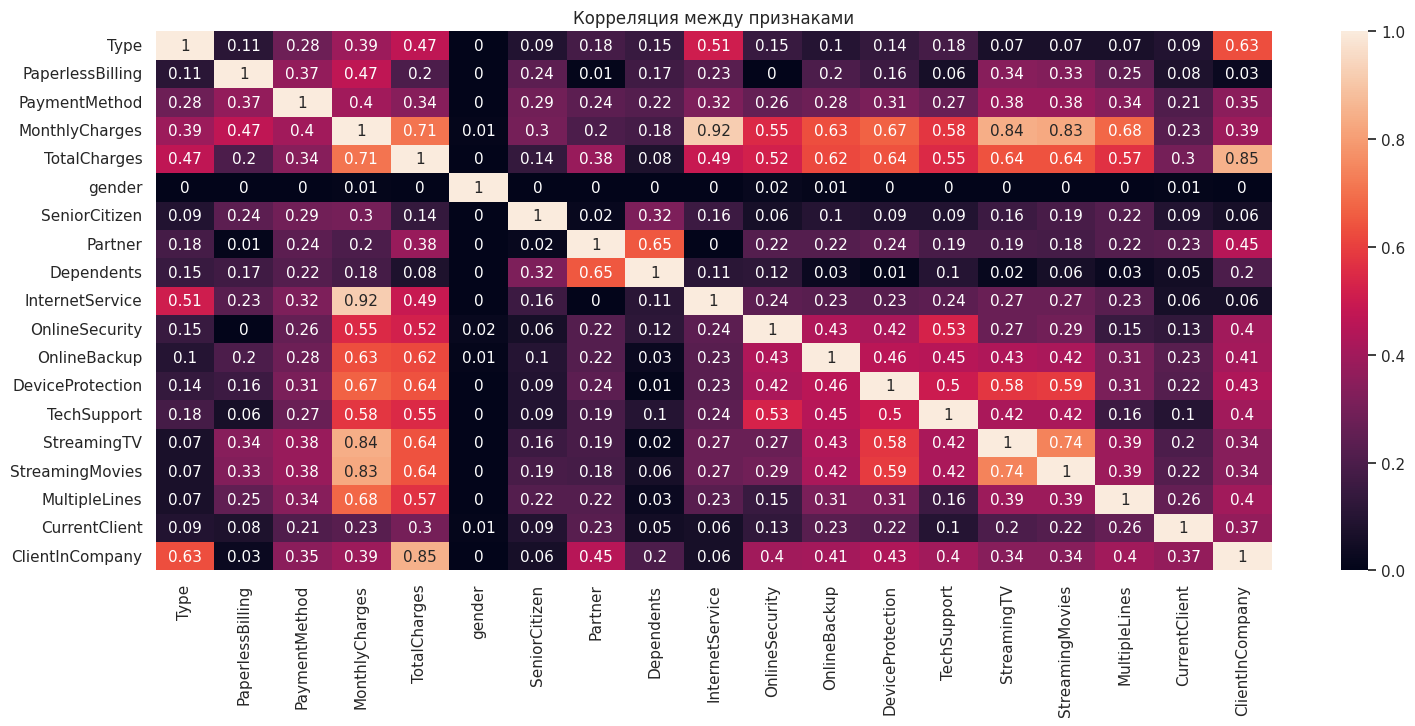

In [19]:
plt.rc('font', size= 11) 
plt.figure(figsize=(18, 7))
sns.heatmap(full_data.data.phik_matrix().round(2), annot = True)
plt.title('Корреляция между признаками')
plt.show()

**По тепловой карте корреляции между признаками:** 
1. можно предположить, что признак пола ни на что не влияет.
2. заметна высокая корреляции признаков `MonthlyCharges` и `TotalCharges` с другими признаками, они будут удалены при подготовке признаков для линейных моделей. 

**Посмотрим распределение целевого признака в зависимости от категориальных признаков.**

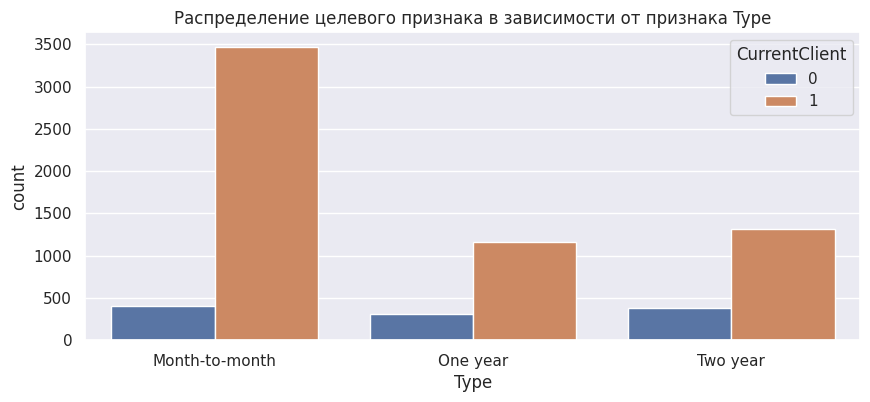

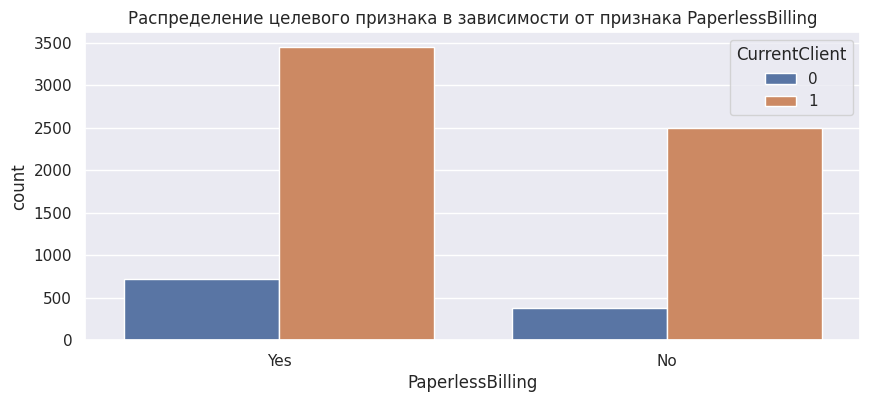

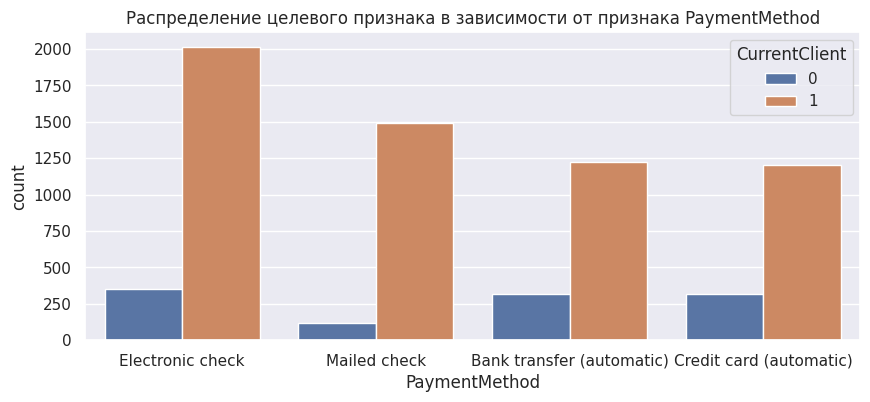

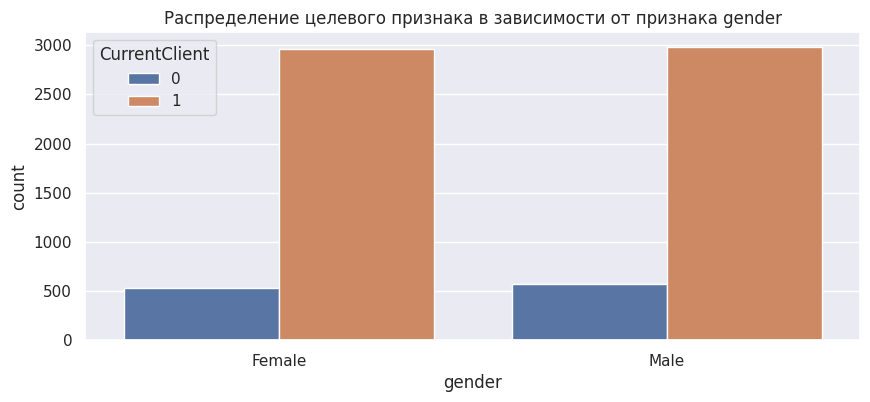

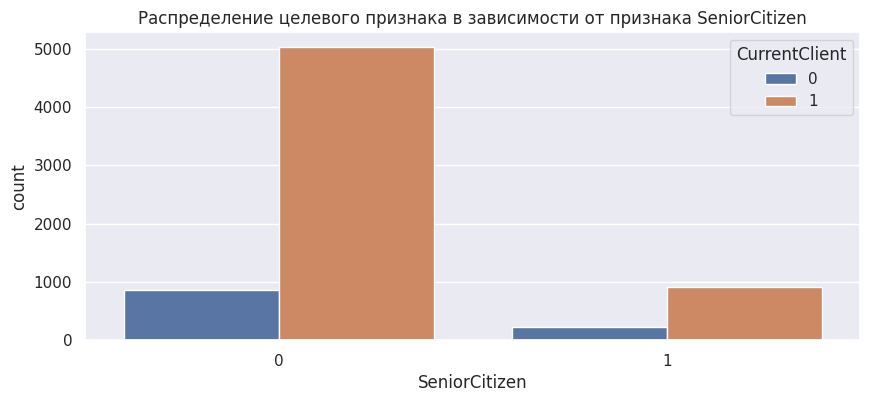

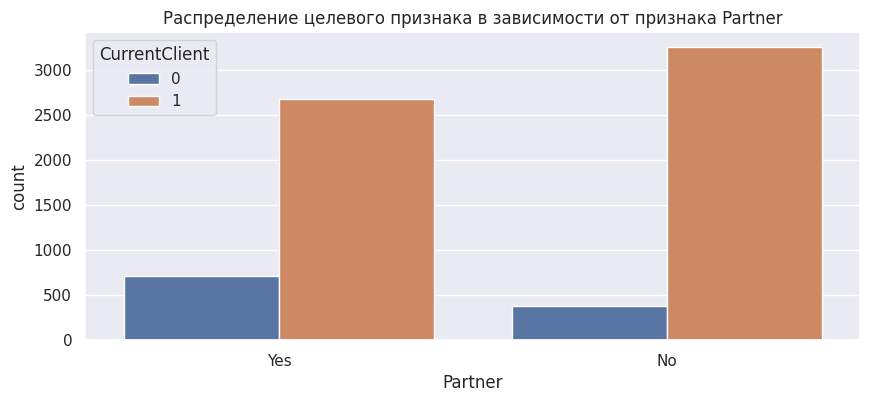

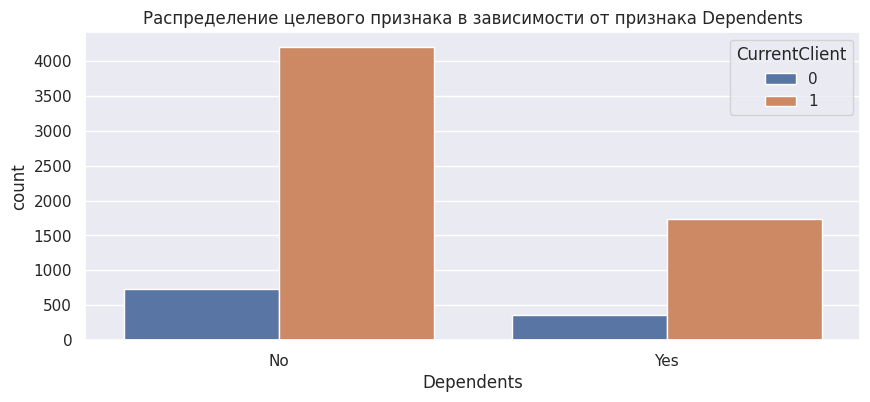

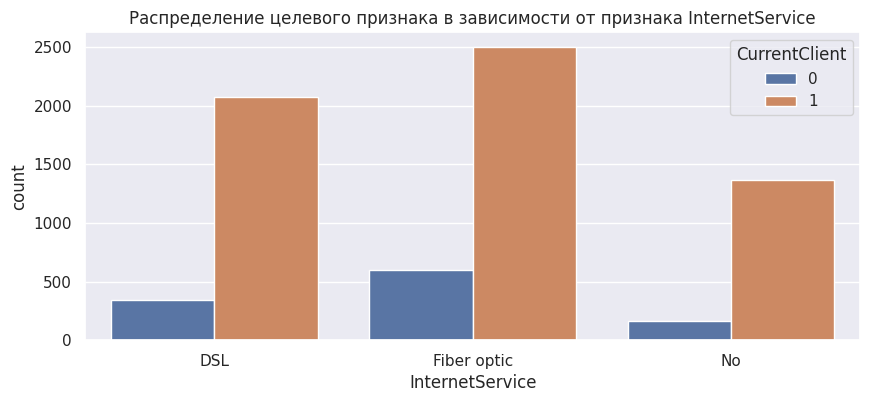

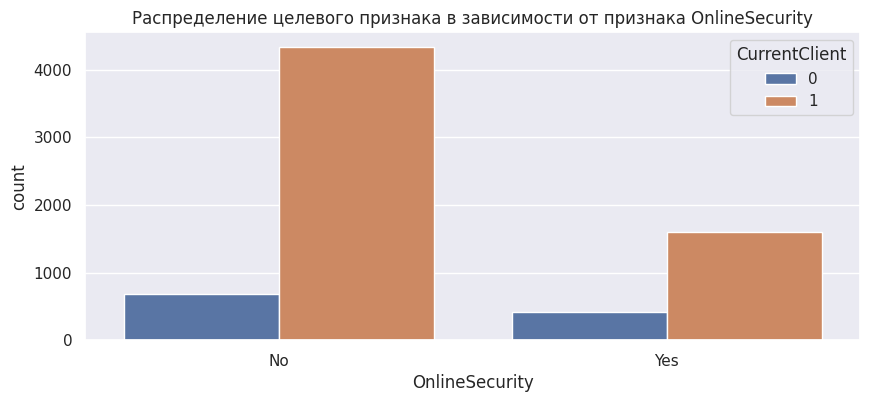

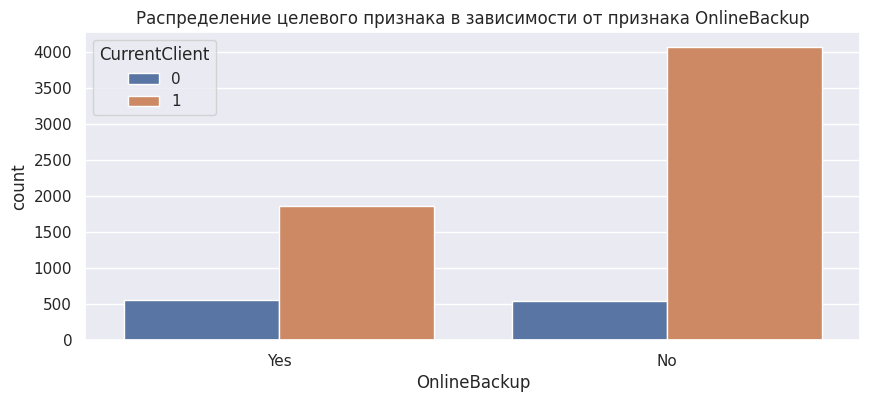

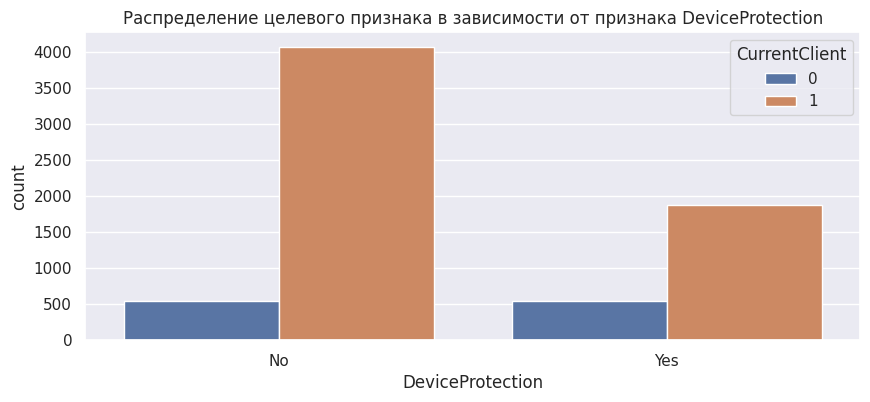

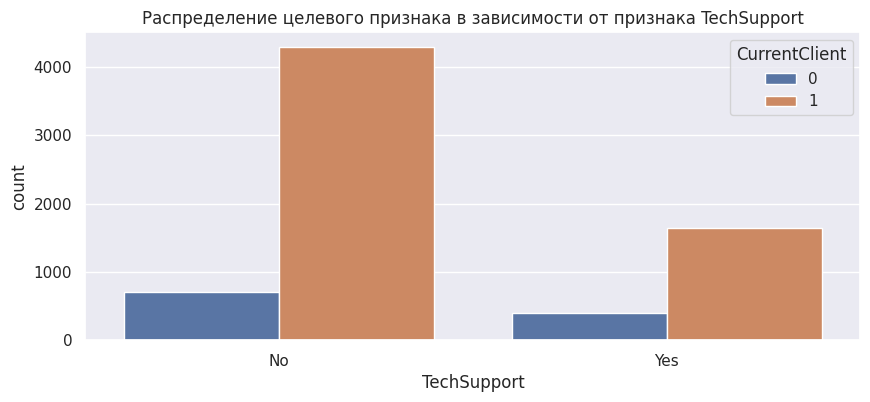

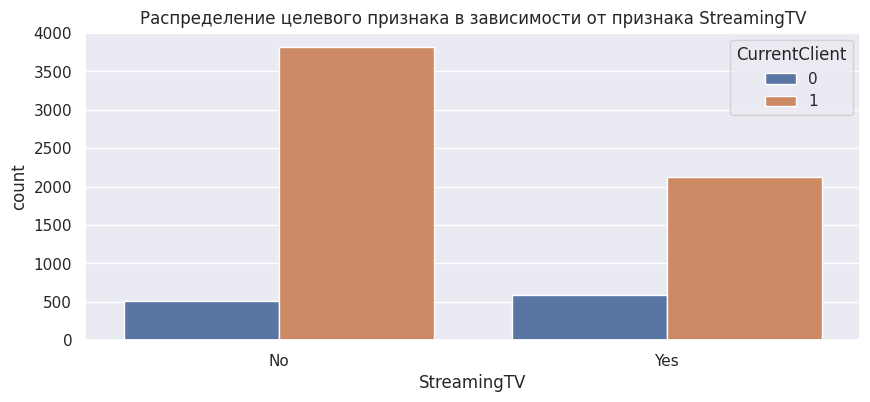

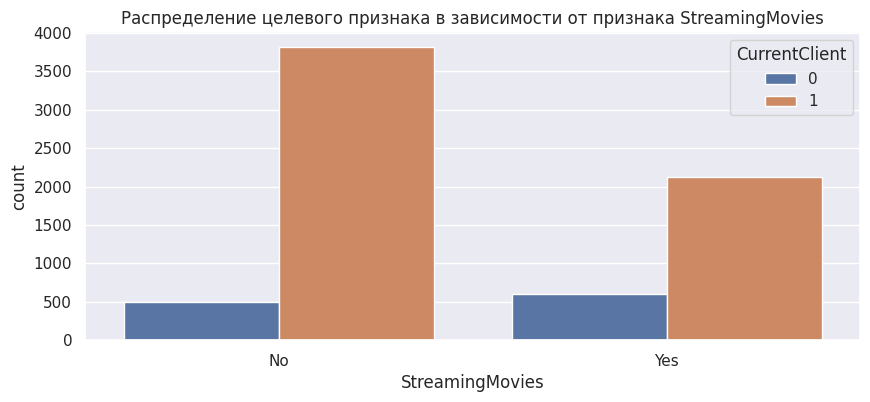

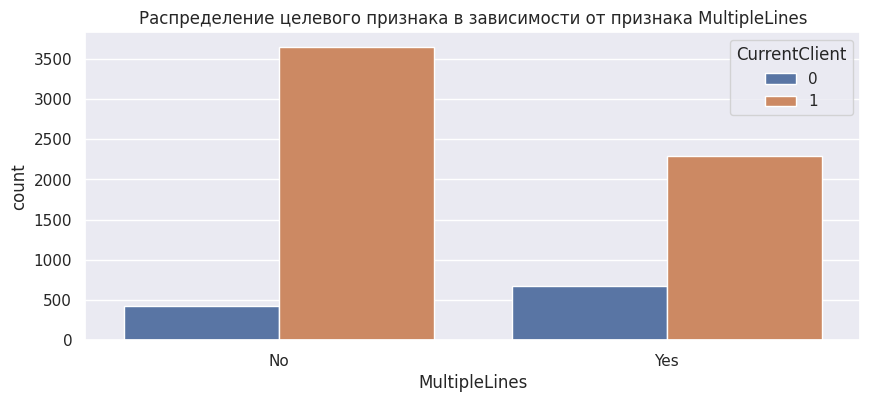

In [20]:
cat_list = [column for column in full_data.data.columns if full_data.data[column].nunique() < 10 
            and column != 'CurrentClient']

for cat in cat_list:
    sns.countplot(x = full_data.data[cat], hue = full_data.data.CurrentClient)
    plt.title(f'Распределение целевого признака в зависимости от признака {cat}')
    plt.show()

**На диаграммах распределения целевого признака в замисимости от пола, разница незаметна.** 

**С учетом всего вышесказанного, можно предположить, что признак пола не влияет на целевой признак. Удалим его из датафрейма.**

In [21]:
full_data.data =  full_data.data.drop(columns=['gender'])

**Перейдем к подготовке данных для исопльзования моделей.**

Для этого создадим класс DataSetForModel со следующими методами:
1. `data_split()`:
    - извлечение признаков и целевого признака;
    - разделение данных на обучающую и тестовую выборки, размер тестовой выборки 25% от исходных данных,
    - так же создание списов названий категориальных и количественных переменных.
    
    
2. `fit_transform_ohe()` - кодирование данных техникой `OneHotEncoder` для линейных моделей.
3. `fit_transform_oe()` - кодирование данных техникой `OrdinalEncoder` для алгоритмов деревьев решений.
4. `transform_lgbm()` - изменение типа данных категориальных признаков на `'category'`.

In [22]:
class DataSetForModel(DataSet):    

    def data_split(self):
        
        features = self.data.drop(columns=['CurrentClient'])
        target = self.data.CurrentClient
        
        self.features_train, self.features_test, self.target_train, self.target_test = train_test_split(
            features, target, test_size=0.25, random_state=250423, stratify=target)
        
        self.cat_list = [column for column in self.features_train.columns 
                         if self.features_train[column].nunique() < 10]
        self.num_list = list(set(self.features_train.columns) - set(cat_list))

    
    def fit_transform_ohe(self):

        encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
        
        encoder.fit(self.features_train[self.cat_list])

        new_columns = encoder.get_feature_names_out(self.cat_list) 

        encoder_df = pd.DataFrame(encoder.transform(self.features_train[self.cat_list]).toarray (), 
                                                    columns=new_columns, 
                                                    index=self.features_train.index)

        self.features_train = self.features_train[self.num_list].join(encoder_df)

        encoder_df = pd.DataFrame(encoder.transform(self.features_test[self.cat_list]).toarray (), 
                                                    columns=new_columns, 
                                                    index=self.features_test.index)

        self.features_test = self.features_test[self.num_list].join(encoder_df)


    def fit_transform_oe(self):

        encoder = OrdinalEncoder()        

        encoder_df = pd.DataFrame(encoder.fit_transform(
                                  self.features_train[self.cat_list]),
                                  columns=self.cat_list,
                                  index=self.features_train.index)

        self.features_train = self.features_train[self.num_list].join(encoder_df)

        encoder_df = pd.DataFrame(encoder.transform(self.features_test[self.cat_list]),
                                                    columns=self.cat_list,
                                                    index=self.features_test.index)

        self.features_test = self.features_test[self.num_list].join(encoder_df) 

    def transform_lgbm(self):
        
        self.features_train[self.cat_list] = self.features_train[self.cat_list].astype('category')
        self.features_test[self.cat_list] = self.features_test[self.cat_list].astype('category')  


**Создадим класс Model для моделей со следующими методами:**
1. `random_search()` - поиск наилучших параметров модели с использованием `RandomizedSearchCV`.
2. `get_prediction` - получение предсказаний модели на тестовой выборке.
3. `confusion_matrix_creating` - построение матрицы ошибок.
4. `roc_curve_creating` - построение ROC-кривой.

In [23]:
class Model:
    score_table = pd.DataFrame()
    
    def __init__(self, model, params):
        self.name = model.__name__
        self.model = model(random_state=250423)
        self.params = params  

    def random_search(self, data):
        self.model = RandomizedSearchCV(self.model, 
                                        self.params,                                          
                                        scoring=['roc_auc', 'accuracy'],
                                        refit='roc_auc',
                                        random_state=250423)

        self.model.fit(data.features_train, data.target_train)
        __class__.score_table.loc[self.name, ['roc_auc_score']] = self.model.best_score_
        print(self.model.best_params_)
        print(abs(self.model.best_score_))

    def get_prediction(self, data):        
        self.probabilities_valid = self.model.best_estimator_.predict_proba(data.features_test)        
        self.probabilities_one_valid = self.probabilities_valid[:, 1]
        self.auc_roc = roc_auc_score(data.target_test, self.probabilities_one_valid)
        print(self.auc_roc)
        
        self.prediction = self.model.best_estimator_.predict(data.features_test)
        self.acc_score = accuracy_score(self.prediction, data.target_test)
        self.crosstab = pd.crosstab(self.prediction, data.target_test)
        
    def confusion_matrix_creating(self, data):
        plt.figure(figsize=(12, 5))
        labels = np.char.add([['TN\n', 'FP\n'],['FN\n', 'TP\n']], 
                     confusion_matrix(data.target_test, self.prediction).astype('str'))

        sns.heatmap(confusion_matrix(data.target_test, self.prediction),            
            annot = labels,
            fmt='')
        plt.xlabel('Предсказания')
        plt.ylabel('Ответы')
        plt.show()
    
    def roc_curve_creating(self, data):
        fpr, tpr, thresholds = roc_curve(data.target_test, self.probabilities_one_valid)
        sns.set(rc={'figure.figsize':(7, 7)})

        plt.plot(fpr, tpr)     

        plt.plot([0, 1], [0, 1], linestyle='--')     

        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])     

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')     

        plt.title(f'ROC-кривая модели "{self.name}"')
        plt.show() 
    

Создадим класс Pipeline со следующими методами:
1. `logistic_regression` содержит:
    - разделение данных на обучающую и тестовую выборки методом `data_split()` класса DataSetForModel;
    - кодирование данных техникой `OneHotEncoder` методом `fit_transform_ohe()` класса DataSetForModel;
    - поиск оптимальных параметров `RandomizedSearchCV` методом `random_search()` класса Model.
    
    
2. `random_forest` содержит:
    - разделение данных на обучающую и тестовую выборки методом `data_split()` класса DataSetForModel;
    - кодирование данных техникой `OrdinalEncoder` методом `fit_transform_oe()` класса DataSetForModel;
    - поиск оптимальных параметров `RandomizedSearchCV` методом `random_search()` класса Model.
    
    
3. `lgbm` содержит:
    - разделение данных на обучающую и тестовую выборки методом `data_split()` класса DataSetForModel;
    - изменение типа данных категориальных признаков на `'category'` методом `transform_lgbm()` класса DataSetForModel;
    - поиск оптимальных параметров `RandomizedSearchCV` методом `random_search()` класса Model.
    
    
4. `start_process` определяет тип модели по названию и запускает один из 3 вышестоящих методов.

In [24]:
class Pipeline:

    def __init__(self, model, dataset):
        self.model = model
        self.dataset = dataset

    def logistic_regression(self):
        self.dataset.data_split()        
        self.dataset.fit_transform_ohe()        
        self.model.random_search(self.dataset)

    def random_forest(self):
        self.dataset.data_split()        
        self.dataset.fit_transform_oe()        
        self.model.random_search(self.dataset)

    def lgbm(self):
        self.dataset.data_split()
        self.dataset.transform_lgbm()
        self.model.random_search(self.dataset)
        
    def start_process(self):
        if self.model.name == 'LogisticRegression':
            self.logistic_regression()            

        if self.model.name == 'RandomForestClassifier':
            self.random_forest()

        if self.model.name == 'LGBMClassifier':
            self.lgbm()

**Для линейной модели удалим признаки с сильной корреляцией `MonthlyCharges`, `TotalCharges`.**

In [25]:
full_data_lm = copy.deepcopy(full_data)

In [26]:
full_data_lm.data = full_data_lm.data.drop(columns=['MonthlyCharges', 'TotalCharges'])

**Выводы по шагу 2:**
1. Создан новый признак, определяющий срок пользования услугами для каждого клиента; удалены даты начала и окончания пользования услугами.
2. Построена теплова карта корреляции признаков, по ней видно, что:
    - признак пола не влияет на другие признаки;
    - есть высокая корреляции признаков MonthlyCharges и TotalCharges с другими признаками; для линейной модели эти признаки были удалены.
3. Созданы классы:
    - DataSetForModel - для подготовки датафреймов для моделей машинного обучения;
    - Model, содержащий методы, которые обеспечивают поиск наилучших параметров моделей, тестирование и получение метрик;
    - Pipeline, определяющий тип модели и запускающий обратку данных и процесс обучения модели. 

## Обучение моделей
### Модель LogisticRegression

**Обучим модель LogisticRegression и определим метрику AUC ROC.**

In [27]:
%%time
log_reg_params = {'penalty' : ['l2', 'none'],
                  'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

log_reg = Pipeline(Model(LogisticRegression, log_reg_params),  
              DataSetForModel('Liner model data', full_data_lm.data))

log_reg.start_process()

{'solver': 'newton-cg', 'penalty': 'l2'}
0.7571372145705298
CPU times: user 18.2 s, sys: 46.1 s, total: 1min 4s
Wall time: 5.13 s


### Модель RandomForestClassifier

**Обучим модель RandomForestClassifier и определим метрику AUC ROC.**

In [28]:
%%time
rand_forest_params = {'n_estimators' : list(range(10, 201, 20)),
                      'max_depth': list(range(1, 9, 2)),
                      'criterion': ['gini', 'entropy']}

rand_forest = Pipeline(Model(RandomForestClassifier, rand_forest_params),  
                       DataSetForModel('Tree model data', full_data.data))

rand_forest.start_process()

{'n_estimators': 70, 'max_depth': 7, 'criterion': 'entropy'}
0.8330833347054802
CPU times: user 12 s, sys: 771 ms, total: 12.8 s
Wall time: 11.8 s


### Модель LGBMClassifier

**Обучим модель LGBMClassifier и определим метрику AUC ROC.**

In [29]:
%%time
lgbm_params = {'learning_rate': [0.2, 0.4, 0.6, 0.8],
               'max_depth' : list(range(2, 11, 2)),
               'n_estimators': [100, 120, 140, 160]}

lgbm = Pipeline(Model(lgb.LGBMClassifier, lgbm_params),  
                DataSetForModel('LGB model data', full_data.data))

lgbm.start_process()

{'n_estimators': 120, 'max_depth': 4, 'learning_rate': 0.6}
0.8814445453429546
CPU times: user 1min 6s, sys: 0 ns, total: 1min 6s
Wall time: 4.46 s


**Посмотрим результаты по трем моделям.**

In [30]:
Model.score_table

,roc_auc_score
LogisticRegression,0.757137
RandomForestClassifier,0.833083
LGBMClassifier,0.881445


Из таблицы видно, что лучше моделью является модель LGBMClassifier с параметрами:

In [31]:
print(lgbm.model.model.best_params_)

{'n_estimators': 120, 'max_depth': 4, 'learning_rate': 0.6}


Целевая метрика, достигнутая на это моделе:

In [32]:
print(lgbm.model.model.best_score_)

0.8814445453429546


**Выводы по шагу 3:**
1. Рассмотрены три модели машинного обучения: LogisticRegression, RandomForestClassifier, LGBMClassifier.
2. Для каждой определены оптимальные параметры.
3. Наилучшие результаты показала модель LGBMClassifier с параметрами:
    - 'n_estimators': 120; 
    - 'max_depth': 4; 
    - 'learning_rate': 0.6.

## Тестирование

**Проведем итоговое тестирование лучшей модели и получим значение метрики AUC ROC на тестовой выборке.**

In [33]:
lgbm.model.get_prediction(lgbm.dataset)

0.9043362290468615


**Получим значение дополнительной метрики Accuracy:**

In [34]:
lgbm.model.acc_score

0.9063032367972743

**Визуализируем результат, построив ROC-кривую и матрицу ошибок.**

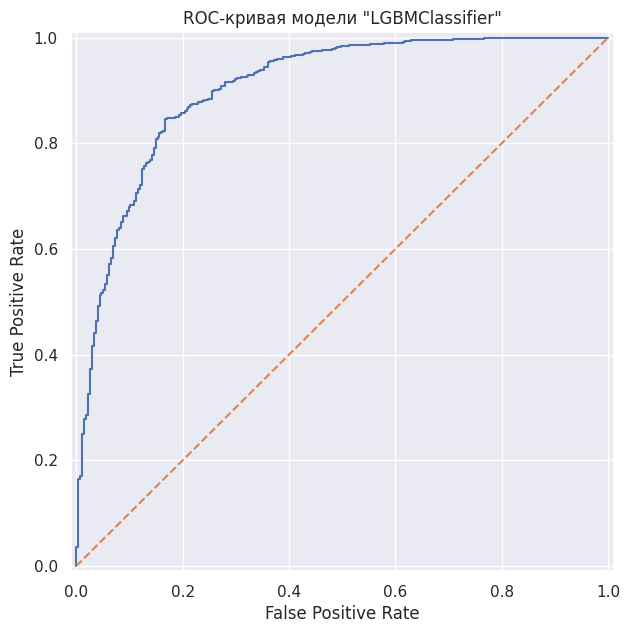

In [35]:
lgbm.model.roc_curve_creating(lgbm.dataset)

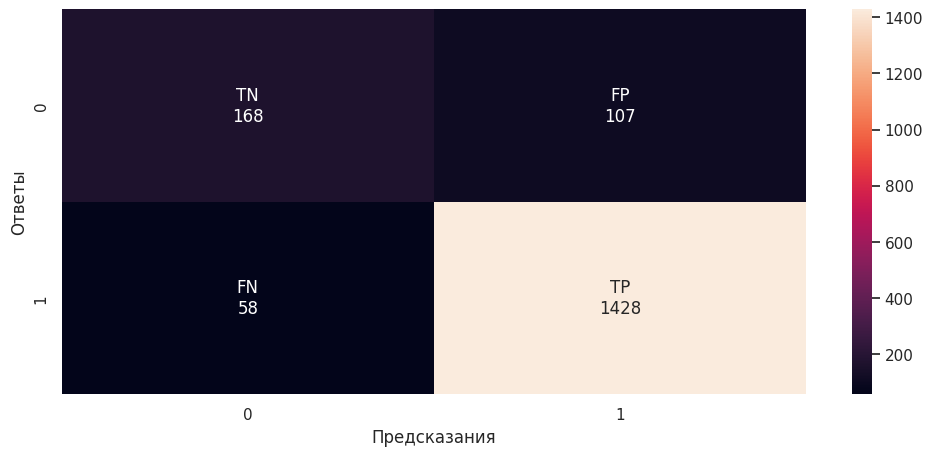

In [36]:
lgbm.model.confusion_matrix_creating(lgbm.dataset)

**Проведем исследование важности признаков лучшей модели.**

In [37]:
importances = lgbm.model.model.best_estimator_.feature_importances_  
feature_list = lgbm.dataset.features_train.columns 
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})  
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)  
feature_results.head(10) 

,feature,importance
0,ClientInCompany,475
1,MonthlyCharges,322
2,TotalCharges,280
3,Type,57
4,Partner,35
5,DeviceProtection,26
6,OnlineBackup,25
7,Dependents,24
8,PaperlessBilling,24
9,OnlineSecurity,22


**Визуализируем важность признаков.**

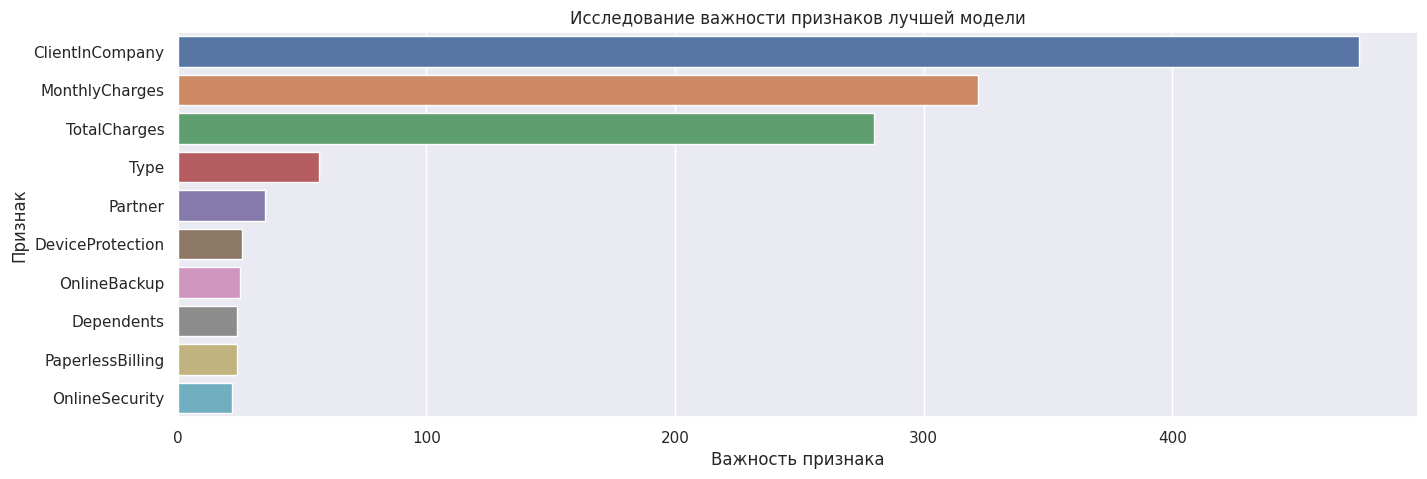

In [38]:
plt.figure(figsize=(16, 5))
sns.barplot(y=feature_results.head(10)['feature'], x=feature_results.head(10)['importance'])
plt.title('Исследование важности признаков лучшей модели')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.show()

**Выводы по шагу 4:**
1. Проведено итоговое тестирование лучшей модели на тестовой выборке.
2. Результаты метрик:
    - основная метрика AUC ROC 0.9043362290468615;
    - дополнительная метрика Accuracy 0.9063032367972743.
3. Результат визуализирован посредством ROC-кривой и матрицы ошибок.
4. Проведено исследование важности признаков, наиболее значимые `ClientInCompany`, `MonthlyCharges`, `TotalCharges`.

## Отчет

Перед нами стояла задача построения модели, способной спрогнозировать, уйдет клиент или останется; для ее решения был составлен план.

В решении задачи были следующие ключевые шаги:
1. Исследовательский анализ данных.
2. Объединение исходных таблиц по идентификационныму номеру клиента.
3. Заполнение пропусков, появивщихся в результате объединения данных.
4. Определение целевого признака. 
5. Создание нового признака `ClientInCompany` и удаление признаков `BeginDate`, `EndDate`, `gender`.
6. Разделение данных на обучающую и тестовую выборки, кодирование данных.
7. Создание и обучение моделей МО, определение лучшей по метрике на кросс-валидации.
8. Проверка лучшей модели на тестовых данных.
9. Исследование важности признаков лучшей модели.

Результаты значений целевой метрики, полученные на обучающей выборке: 

| Модель | roc_auc_score |
|---|---|
| LogisticRegression | 0.757137 |
| RandomForestClassifier | 0.833477 |
| LGBMClassifier | 0.881445 |

Как видно из таблицы, наилучший результат показала модель LGBMClassifier (roc_auc_score=0.881445). В процессе обучения на обучающих данных, были найдены гиперпараметры, позволившие достичь необходимого результата:
```
'n_estimators': 120
'max_depth': 4
'learning_rate': 0.6
```

Итоговое тестирование лучшей модели показало следующие результаты:
- основная метрика AUC ROC 0.9043362290468615;
- дополнительная метрика Accuracy 0.9063032367972743.

Для обучения лучшей модели использовались признаки (приведены в порядке убывания важности):

|   | Признак  | Расшифровка |
|---|---|---|
| 1 | ClientInCompany | Срок пользования услугами |
| 2 | MonthlyCharges | Ежемесячные траты на услуги |
| 3 | TotalCharges | Всего потрачено денег на услуги |
| 4 | Type | Тип оплаты |
| 5 | Partner | Наличие супруга(и) |
| 6 | DeviceProtection | Антивирус |
| 7 | OnlineBackup | Облачное хранилище файлов для резервного копирования данных |
| 8 | Dependents |  Наличие иждивенцев |
| 9 | PaperlessBilling | Безналичный расчет |
| 10 | OnlineSecurity | Блокировки небезопасных сайтов |
| 11 | MultipleLines | Наличие возможности ведения параллельных линий во время звонка |
| 12 | InternetService |  Тип подключения интернета |
| 13 | StreamingMovies | Каталог фильмов |
| 14 | TechSupport |  Выделенная линия технической поддержки |
| 15 | SeniorCitizen | Наличие пенсионного статуса по возрасту |
| 16 | PaymentMethod | Способ оплаты |
| 17 | StreamingTV |  Стриминговое телевидение |


Особенности предобработки признаков:
- признак ClientInCompany отсутствовал в исходных данных и был сгенерирован как разность дат окончания и начала пользования услугами;
- признаки `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`,  `StreamingTV`, `StreamingMovies`, `MultipleLines` обозначают услуги и после объединения данных содержали пропуски значений. Эти пропуски означали, что у пользователя данная услуга не подключена; они были заполнены строковым значением 'No';
- пустые значения в столбце `TotalCharges` в виде пробелов были заменены на нули;
- категориальные переменные были обработаны техникой OneHotEncoder для линейной модели, техникой OrdinalEncoder для алгоритмов деревьев решений, для бустинговой модели тип данных был изменен на 'category' для возможности использования встроенного кодировщика.